In [70]:
import pandas as pd
from pathlib import Path
import pickle
from datetime import datetime, timedelta
import numpy as np

In [5]:
events_dir = Path('/mnt/fourth_events')

In [6]:
moments = []
for events_subdir in events_dir.iterdir():
    moments_file = Path(events_subdir, 'moments.pickle')
    
    if moments_file.exists():
        with open(moments_file, 'rb') as f:
            event_moments = pickle.load(f)
        for m in event_moments:
            moments.append(m)
    else:
        print(f'No moments.pickle for {events_subdir}.')

No moments.pickle for /mnt/fourth_events/92.
No moments.pickle for /mnt/fourth_events/93.
No moments.pickle for /mnt/fourth_events/165.
No moments.pickle for /mnt/fourth_events/1107.


In [7]:
print(moments[0])

{'img_path': '/mnt/usb/events/683/images/0.jpg', 'train_prediction_value': 0.9197917, 'timestamp': '20191221_193808', 'event_number': 683}


In [30]:
events = {}
for m in moments:
    event_number = m['event_number']
    timestamp = datetime.strptime(m['timestamp'], '%Y%m%d_%H%M%S')
    
    if event_number in events:
        if timestamp < events[event_number]['start_time']:
            events[event_number]['start_time'] = timestamp
        elif timestamp > events[event_number]['end_time']:
            events[event_number]['end_time'] = timestamp
    else:
        events[event_number] = {'start_time': datetime.max, 'end_time': datetime.min}

In [39]:
events_df = pd.DataFrame.from_dict(events, orient='index')
events_df.head()

,start_time,end_time
683,2019-12-21 19:38:12,2019-12-21 19:48:35
2105,2020-03-06 15:17:28,2020-03-06 15:17:46
2017,2020-03-03 00:38:22,2020-03-03 00:38:39
435,2019-12-14 06:09:50,2019-12-14 06:11:08
1199,2020-01-30 21:57:35,2020-01-30 22:08:22


In [40]:
events_df['duration'] = events_df['end_time'] - events_df['start_time']
events_df.head()

,start_time,end_time,duration
683,2019-12-21 19:38:12,2019-12-21 19:48:35,00:10:23
2105,2020-03-06 15:17:28,2020-03-06 15:17:46,00:00:18
2017,2020-03-03 00:38:22,2020-03-03 00:38:39,00:00:17
435,2019-12-14 06:09:50,2019-12-14 06:11:08,00:01:18
1199,2020-01-30 21:57:35,2020-01-30 22:08:22,00:10:47


In [46]:
events_df = events_df.loc[events_df['duration'] > timedelta(minutes=1)]
events_df.head()

,start_time,end_time,duration
683,2019-12-21 19:38:12,2019-12-21 19:48:35,00:10:23
435,2019-12-14 06:09:50,2019-12-14 06:11:08,00:01:18
1199,2020-01-30 21:57:35,2020-01-30 22:08:22,00:10:47
826,2020-01-02 17:37:03,2020-01-02 17:38:09,00:01:06
3649,2020-07-25 14:28:57,2020-07-25 14:35:02,00:06:05


In [55]:
events_df['date'] = events_df.apply(lambda e: e['start_time'].date(), axis=1)
events_df.head()

,start_time,end_time,duration,date
683,2019-12-21 19:38:12,2019-12-21 19:48:35,00:10:23,2019-12-21
435,2019-12-14 06:09:50,2019-12-14 06:11:08,00:01:18,2019-12-14
1199,2020-01-30 21:57:35,2020-01-30 22:08:22,00:10:47,2020-01-30
826,2020-01-02 17:37:03,2020-01-02 17:38:09,00:01:06,2020-01-02
3649,2020-07-25 14:28:57,2020-07-25 14:35:02,00:06:05,2020-07-25


In [57]:
events_df['month'] = events_df.apply(lambda e: e['start_time'].month, axis=1)
events_df.head()

,start_time,end_time,duration,date,month
683,2019-12-21 19:38:12,2019-12-21 19:48:35,00:10:23,2019-12-21,12
435,2019-12-14 06:09:50,2019-12-14 06:11:08,00:01:18,2019-12-14,12
1199,2020-01-30 21:57:35,2020-01-30 22:08:22,00:10:47,2020-01-30,1
826,2020-01-02 17:37:03,2020-01-02 17:38:09,00:01:06,2020-01-02,1
3649,2020-07-25 14:28:57,2020-07-25 14:35:02,00:06:05,2020-07-25,7


In [62]:
events_df['day'] = events_df.apply(lambda e: e['start_time'].day, axis=1)
events_df.head()

,start_time,end_time,duration,date,month,day
683,2019-12-21 19:38:12,2019-12-21 19:48:35,00:10:23,2019-12-21,12,21
435,2019-12-14 06:09:50,2019-12-14 06:11:08,00:01:18,2019-12-14,12,14
1199,2020-01-30 21:57:35,2020-01-30 22:08:22,00:10:47,2020-01-30,1,30
826,2020-01-02 17:37:03,2020-01-02 17:38:09,00:01:06,2020-01-02,1,2
3649,2020-07-25 14:28:57,2020-07-25 14:35:02,00:06:05,2020-07-25,7,25


In [ ]:
events_df['hour'] = events_df.apply(lambda e: e['start_time'].hour, axis=1)
events_df.head()

In [86]:
# Average and standard deviation of event duration in each month
events_df['duration_int'] = events_df['duration'].values.astype(np.int64)
duration_means = events_df.groupby('month')['duration_int'].mean()
duration_stds = events_df.groupby('month')['duration_int'].std()
duration_means = pd.to_timedelta(duration_means)
duration_stds = pd.to_timedelta(duration_stds)
duration_maxes = events_df.groupby('month')['duration_int'].max()
duration_mins = events_df.groupby('month')['duration_int'].min()
duration_maxes = pd.to_timedelta(duration_maxes)
duration_mins = pd.to_timedelta(duration_mins)
# march_events_df = events_df[events_df['month'] == 3]
print('MEAN:\n', duration_means, '\n')
print('STD:\n', duration_stds, '\n')
print('MAX:\n', duration_maxes, '\n')
print('MIN:\n', duration_mins, '\n')

MEAN:
 month
1    00:07:30.470108
2    00:09:09.761229
3    00:09:49.353200
4    00:07:26.360784
5    00:07:42.934272
6    00:11:12.858064
7    00:13:54.638036
12   00:10:38.570743
Name: duration_int, dtype: timedelta64[ns] 

STD:
 month
1    00:10:36.727322
2    00:14:01.180093
3    00:13:30.009807
4    00:10:55.571713
5    00:10:16.572108
6    00:21:09.552352
7    00:21:27.786639
12   00:36:18.994865
Name: duration_int, dtype: timedelta64[ns] 

MAX:
 month
1    01:58:05
2    03:18:18
3    01:58:46
4    01:53:14
5    01:03:39
6    02:46:45
7    03:10:47
12   11:22:44
Name: duration_int, dtype: timedelta64[ns] 

MIN:
 month
1    00:01:06
2    00:01:02
3    00:01:03
4    00:01:03
5    00:01:02
6    00:01:01
7    00:01:02
12   00:01:01
Name: duration_int, dtype: timedelta64[ns] 



In [90]:
event_stats_df = pd.DataFrame({'mean': duration_means, 'std': duration_stds, 'max': duration_maxes, 'min': duration_mins})
event_stats_df.to_html('temp.html')

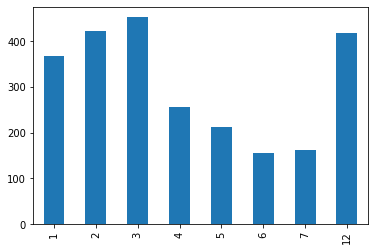

In [61]:
ax = events_df['month'].value_counts().sort_index().plot(kind='bar')
ax.figure.savefig('events_vs_month.jpg')

In [ ]:
ax = events_df['hour'].value_counts().sort_index().plot(kind='bar')
ax.figure.savefig('events_vs_hour.jpg')

In [ ]:
# QUESTIONS / TODO
# - Get the first and last moment of each event. From this information, create a new DataFrame, where each entry contains the date, start time, and end time.
# - Filter out events that are less than 30 seconds long.
# - Create a histogram of # events vs hour of day, per month and per year.
# - Statistics about # daily events per month. Average, median, standard deviation, min, max, etc. Same stats for duration.
#   those daily statistics for January, February, etc.